# Caso cuadrado

In [1]:
import numpy as np
import kdsource as kds
import mcpl
import matplotlib.pyplot as plt

N = int(1E5) # Size of particle list

pt = "n"     # Particle type: neutron

# Energy
E0 = 0.5
sigma_u = 1
mu_u_1 = 5
mu_u_2 = 9
us_1 = np.random.normal(mu_u_1, sigma_u, (int(N/2),1))
us_2 = np.random.normal(mu_u_2, sigma_u, (int(N/2),1))
us = np.concatenate((us_1, us_2), axis=0)
Es = E0*np.ones(N)#E0 * np.exp(-us)
Es = Es.reshape(N,1)
# Position
poss_1 = np.random.uniform(-1, 1, (int(N/2),3))
poss_2 = np.random.uniform(-1, 1, (int(N/2),3))
poss = np.concatenate((poss_1, poss_2), axis=0)
# Direction
mus = np.sqrt(np.random.uniform(0,1,N))
phis = np.random.uniform(-np.pi,np.pi,N)
dxs = np.sqrt(1-mus**2) * np.cos(phis)
dys = np.sqrt(1-mus**2) * np.sin(phis)
dzs = mus
dirs = np.stack((dxs,dys,dzs), axis=1)
# Time
t = np.zeros(N)
t = t.reshape(N,1)
# Stack energies, positions and directions
parts = np.concatenate((Es,poss,dirs, t), axis=1)
np.random.shuffle(parts)
# Weights
sigma_w = 0.1
ws = np.random.normal(1, sigma_w, N)

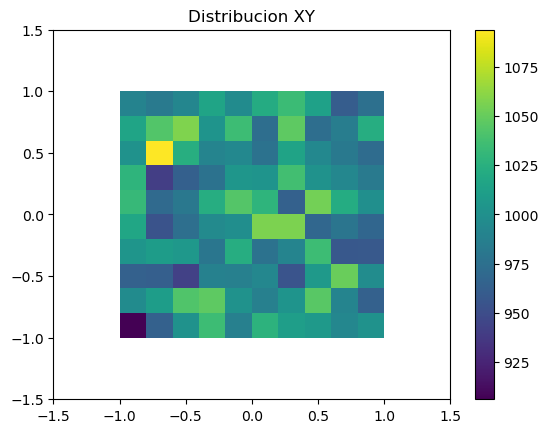

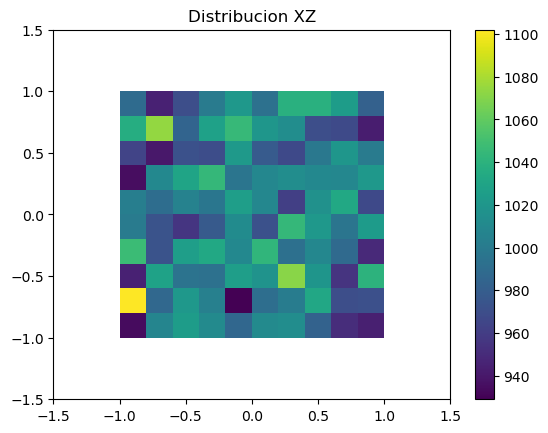

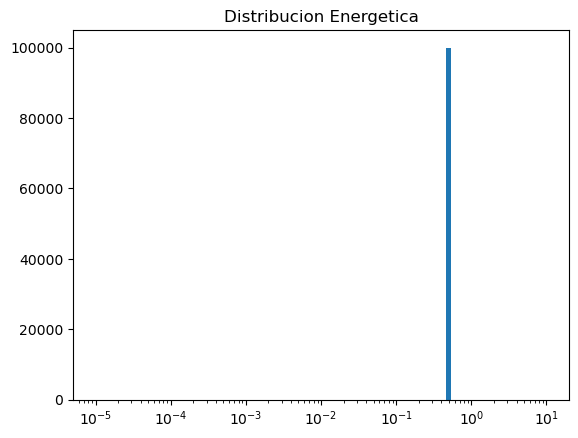

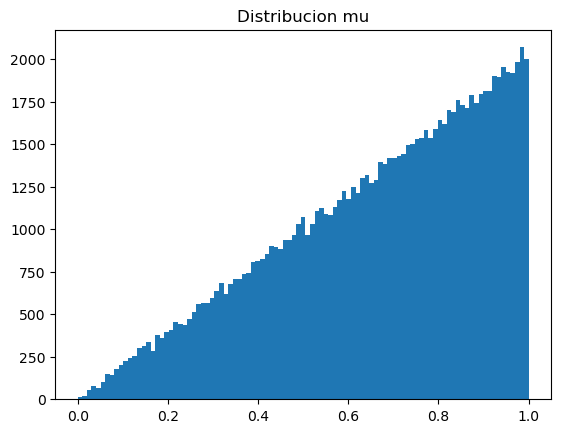

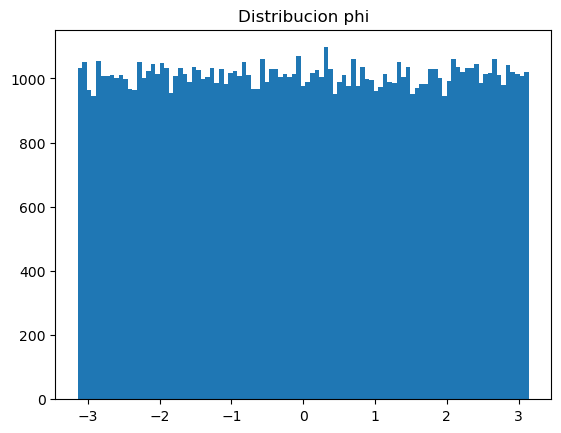

In [2]:
plt.hist2d(poss[:,0], poss[:,1])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title("Distribucion XY")
plt.colorbar()
plt.show()


plt.hist2d(poss[:,0], poss[:,2])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title("Distribucion XZ")
plt.colorbar()
plt.show()


bins = np.logspace(-5,1,100)
plt.hist(Es, bins=bins)
plt.title("Distribucion Energetica")
plt.xscale("log")
plt.show()

bins = np.linspace(0,1,100)
plt.hist(mus, bins=bins)
plt.title("Distribucion mu")
plt.show()

bins = np.linspace(-np.pi,np.pi,100)
plt.hist(phis, bins=bins)
plt.title("Distribucion phi")
plt.show()

In [56]:
ssvfile = "samples.ssv"
kds.plist.savessv(pt, parts, ws, ssvfile)        # Save as SSV file
samples = kds.convert2mcpl(ssvfile, "ssv") # Convert to MCPL

Writing particles into SSV file...
Done. All particles written into samples.ssv
Converting ssv file to MCPL...
Done. Created samples.mcpl.gz


# Create and optimize KDSource

## Create KDSource

In [57]:
# PList: wrapper for MCPL file
plist = kds.PList(samples)
# Geometry: define metrics for variables
geom = kds.Geometry([kds.geom.Energy(),
                    kds.geom.SurfXY(xmin=-1, xmax=1, ymin=-1, ymax=1),
                    kds.geom.Isotrop()])
# Create KDSource
s = kds.KDSource(plist, geom)

Using existing file samples.mcpl.gz
sum_weights = 100048.15228319168
p2 = 101092.18567932514
N = 100000
N_eff = 99014.90118170263


## Optimize bandwidth

In [58]:
# Give a little more importance to energy
var_importance = [3,1,1,1,1,1]

parts,ws = s.plist.get(N=-1)
scaling = s.geom.std(parts=parts)
scaling /= var_importance

In [59]:
# Number of particles to use for optimization.
# A large number (1E5 or more) gives better bandwidths, but takes longer to
# compute.
N = 1E5

Choose one of the available bandwidth optimization methods. Recommended method is Method 3 (adaptive MLCV)

In [60]:
# Method 1: Silverman's Rule: Simple and fast method.
# BW is chosen based on only on the number of particles, and dimension of
# geometry.

s.bw_method = "silv"
s.fit(N, scaling=scaling)

Using 100000 particles for fit.
Calculating bw ... 
Done
Optimal bw (silv) = [[0.29534318 0.16989139 0.17060917 0.13911861 0.13911861 0.13911861]]


Using 10000 particles for fit.
Calculating bw ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    8.4s remaining:   19.5s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    8.5s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    9.3s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.6s finished


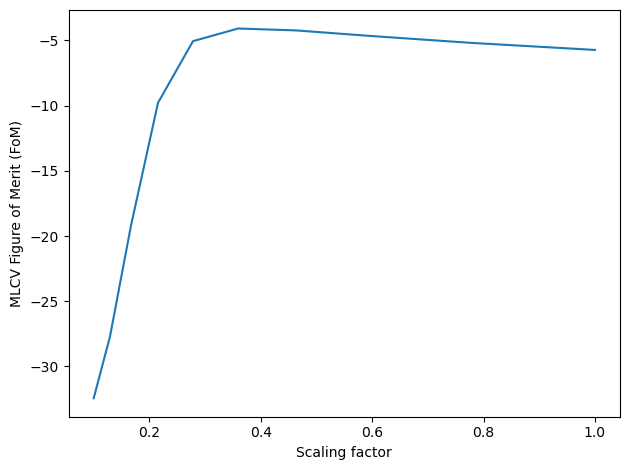

Done
Optimal bw (mlcv) = [[0.13362534 0.07686582 0.07719057 0.06294295 0.06294295 0.06294295]]
Using 100000 particles for fit.


In [61]:
# Method 2: Non-adaptive Maximum Likelihood Cross-Validation:
# Creates a grid of non-adaptive bandwidths and evaluates the
# cross-validation scores on each one, which is an indicator of the
# quality of the estimation. Selects the bandwidth that optimizes
# CV score.

s.bw_method = "mlcv"
seed = None # Default: Use the Silverman's Rule as seed
grid = np.logspace(-1,0,10)

N_cv = int(1E4) # Use a smaller N to reduce computation times
s.fit(N_cv, scaling=scaling, seed=seed, grid=grid)

bw = s.kde.bw
dim = s.geom.dim
bw *= kds.bw_silv(dim,N)/kds.bw_silv(dim,N_cv) # Apply Silverman factor
s = kds.KDSource(plist, geom, bw=bw) # Create new KDSource with adapted BW
s.fit(N=N, scaling=scaling)


Using 100000 particles for fit.
Calculating bw ... 
Using k = 10 neighbors per batch (batch_size = 10000)
Correction factor: f_k = k_float / k = 1.0
Effective total neighbors: K_eff = 100.0
batch = 1 / 10
batch = 2 / 10
batch = 3 / 10
batch = 4 / 10
batch = 5 / 10
batch = 6 / 10
batch = 7 / 10
batch = 8 / 10
batch = 9 / 10
batch = 10 / 10
Done
Optimal bw (knn) = [[0.43732199 0.25156241 0.25262523 0.20599638 0.20599638 0.20599638]
 [0.50214429 0.28885039 0.29007075 0.23653032 0.23653032 0.23653032]
 [0.42170921 0.24258141 0.24360629 0.19864213 0.19864213 0.19864213]
 ...
 [0.45603349 0.2623259  0.2634342  0.21481026 0.21481026 0.21481026]
 [0.41612442 0.23936886 0.24038016 0.19601147 0.19601147 0.19601147]
 [0.57134811 0.32865877 0.33004732 0.26912812 0.26912812 0.26912812]]
Using 10000 particles for fit.
Calculating bw ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    8.9s remaining:   20.8s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   10.4s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   12.7s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   28.2s finished


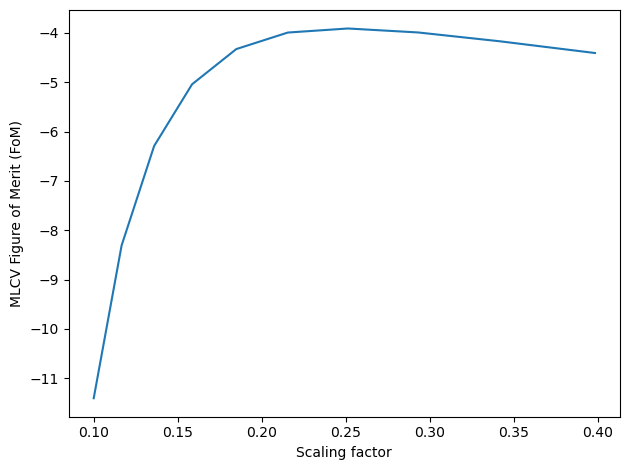

Done
Optimal bw (mlcv) = [[0.10985032 0.06318962 0.06345659 0.05174395 0.05174395 0.05174395]
 [0.12613294 0.07255594 0.07286248 0.05941373 0.05941373 0.05941373]
 [0.10592856 0.0609337  0.06119113 0.04989665 0.04989665 0.04989665]
 ...
 [0.1391396  0.08003781 0.08037596 0.06554039 0.06554039 0.06554039]
 [0.1151674  0.06624818 0.06652808 0.05424851 0.05424851 0.05424851]
 [0.10681469 0.06144342 0.06170302 0.05031405 0.05031405 0.05031405]]
Using 100000 particles for fit.


In [62]:
# Method 3: Adaptive Maximum Likelihood Cross-Validation:
# Creates a grid of adaptive bandwidths and evaluates the
# cross-validation scores on each one, which is an indicator of the
# quality of the estimation. Selects the bandwidth that optimizes
# CV score.
# kNN is used to generate the seed adaptive bandwidth.

# kNN bandwidth
s.bw_method = "knn"
batch_size = 10000 # Batch size for KNN search
k = 10             # Numer of neighbors per batch
s.fit(N, scaling=scaling, batch_size=batch_size, k=k)
bw_knn = s.kde.bw

# MLCV optimization of previously calculated kNN bandwidth
s.bw_method = "mlcv"
N_cv = int(1E4)   # Use a smaller N to reduce computation times
seed = bw_knn[:N_cv] # Use kNN BW as seed (first N elements)
grid = np.logspace(-1,-0.4,10)
s.fit(N_cv, scaling=scaling, seed=seed, grid=grid)
bw_cv = s.kde.bw

# Extend MLCV optimization to full KNN BW
bw_knn_cv = bw_knn * bw_cv[0]/bw_knn[0] # Apply MLCV factor
dim = s.geom.dim
bw_knn_cv *= kds.bw_silv(dim,len(bw_knn))/kds.bw_silv(dim,len(bw_cv)) # Apply Silverman factor
s = kds.KDSource(plist, geom, bw=bw_knn_cv) # Create new KDSource with full BW
s.fit(N=N, scaling=scaling)

# Resample

In [63]:
xmlfile = "source.xml"
s.save(xmlfile) # Save KDSource to XML file

N_resampled = 1E6 # Number of particles to generate with virtual KDE source
!kdtool resample "$xmlfile" -o "resampled" -n $N_resampled
resampled = "resampled.mcpl.gz"

Bandwidth file: samples_bws
Successfully saved parameters file source.xml
Reading xmlfile source.xml...
Done.
Resampling...
MCPL: Attempting to compress file resampled.mcpl with gzip
MCPL: Succesfully compressed file into resampled.mcpl.gz
Successfully sampled 1000000 particles.


A new MCPL file has been created, named "resampled.mcpl.gz", with particles generated from the KDE-based distribution.

In [64]:
import surface_source as ss

In [65]:
olds = ss.SurfaceSource("samples.mcpl.gz")
df_old = olds.get_pandas_dataframe()
df_old

,id,type,E,x,y,z,u,v,w,t,...,px,py,pz,userflags,R,theta,mu,psi,phi,log(E0/E)
0,0,2112,0.5,-0.687006,-0.734552,0.626779,0.445228,-0.118558,0.887533,0.0,...,0.0,0.0,0.0,0,1.005755,-2.322761,0.887533,0.478833,-0.260247,1.60206
1,1,2112,0.5,0.008961,0.785960,-0.717818,0.789415,-0.293976,0.538890,0.0,...,0.0,0.0,0.0,0,0.786011,1.559396,0.538890,1.001678,-0.356487,1.60206
2,2,2112,0.5,-0.556295,-0.394106,-0.970449,-0.296196,0.435127,0.850254,0.0,...,0.0,0.0,0.0,0,0.681751,-2.525220,0.850254,0.554329,2.168460,1.60206
3,3,2112,0.5,0.571499,-0.261093,0.333897,-0.349406,0.505241,0.789080,0.0,...,0.0,0.0,0.0,0,0.628316,-0.428541,0.789080,0.661487,2.175837,1.60206
4,4,2112,0.5,-0.704509,-0.070536,0.559017,0.090205,-0.705676,0.702769,0.0,...,0.0,0.0,0.0,0,0.708031,-3.041804,0.702769,0.791514,-1.443658,1.60206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,2112,0.5,0.435211,-0.373910,-0.715981,-0.455790,0.684300,0.569200,0.0,...,0.0,0.0,0.0,0,0.573774,-0.709780,0.569200,0.965264,2.158384,1.60206
99996,99996,2112,0.5,0.011937,-0.148852,0.797342,0.053510,0.253755,0.965787,0.0,...,0.0,0.0,0.0,0,0.149330,-1.490777,0.965787,0.262334,1.362967,1.60206
99997,99997,2112,0.5,-0.716722,0.802952,-0.000766,0.114137,-0.569133,0.814285,0.0,...,0.0,0.0,0.0,0,1.076301,2.299513,0.814285,0.619300,-1.372876,1.60206
99998,99998,2112,0.5,-0.252693,0.116899,0.582406,-0.569251,-0.239075,0.786636,0.0,...,0.0,0.0,0.0,0,0.278423,2.708299,0.786636,0.665455,-2.743980,1.60206


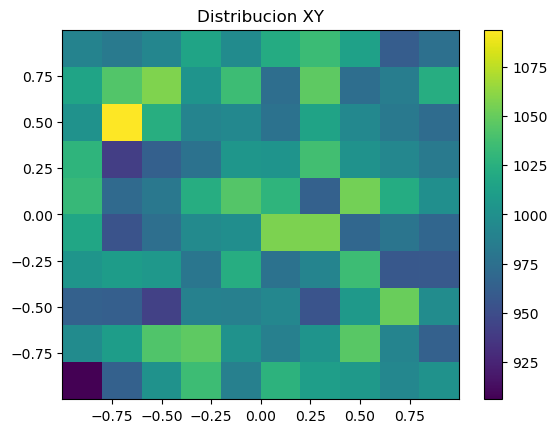

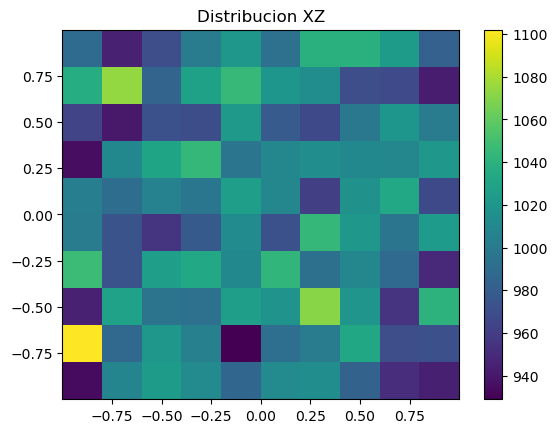

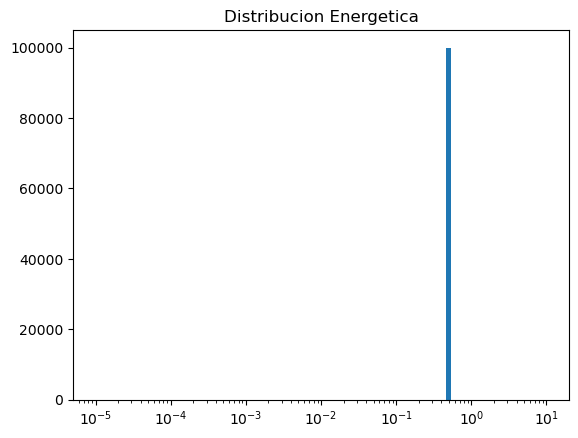

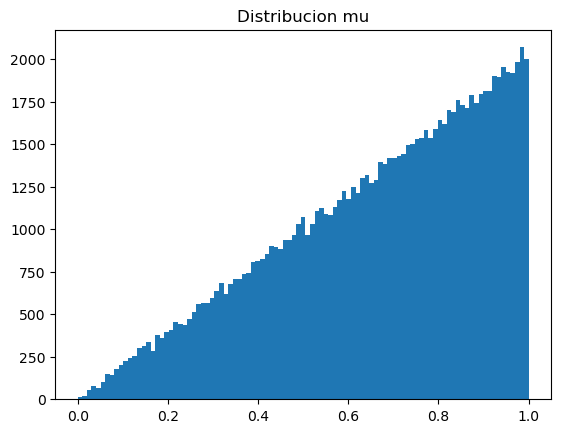

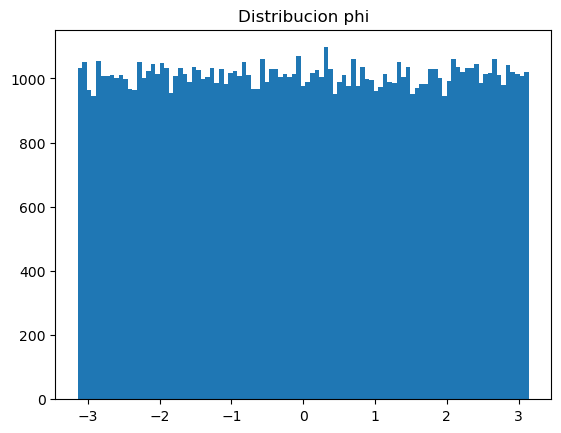

In [66]:
plt.hist2d(df_old["x"], df_old["y"])
#plt.xlim(-1.5,1.5)
#plt.ylim(-1.5,1.5)
plt.title("Distribucion XY")
plt.colorbar()
plt.show()


plt.hist2d(df_old["x"], df_old["z"])
#plt.xlim(-1.5,1.5)
#plt.ylim(-1.5,1.5)
plt.title("Distribucion XZ")
plt.colorbar()
plt.show()


bins = np.logspace(-5,1,100)
plt.hist(df_old["E"], bins=bins)
plt.title("Distribucion Energetica")
plt.xscale("log")
plt.show()

bins = np.linspace(0,1,100)
plt.hist(df_old["mu"], bins=bins)
plt.title("Distribucion mu")
plt.show()

bins = np.linspace(-np.pi,np.pi,100)
plt.hist(df_old["phi"], bins=bins)
plt.title("Distribucion phi")
plt.show()

In [67]:
news = ss.SurfaceSource("resampled.mcpl.gz")
news

In [68]:
df_new = news.get_pandas_dataframe()
df_new

,id,type,E,x,y,z,u,v,w,t,...,px,py,pz,userflags,R,theta,mu,psi,phi,log(E0/E)
0,0,2112,0.451896,0.486255,-0.206447,0.833235,-0.522160,0.606916,0.599168,0.0,...,0.0,0.0,0.0,0,0.528266,-0.401503,0.599168,0.928335,2.281268,1.645992
1,1,2112,0.388200,0.924836,-0.927538,0.443702,-0.003722,-0.282103,0.959377,0.0,...,0.0,0.0,0.0,0,1.309827,-0.786857,0.959377,0.286011,-1.583989,1.711974
2,2,2112,0.366669,-0.296385,0.413623,-0.220310,-0.360559,0.083442,0.928996,0.0,...,0.0,0.0,0.0,0,0.508850,2.192549,0.928996,0.379104,2.914171,1.736755
3,3,2112,0.501105,0.871818,-0.511219,0.596157,-0.620960,-0.714714,0.321857,0.0,...,0.0,0.0,0.0,0,1.010649,-0.530346,0.321857,1.243106,-2.286117,1.601101
4,4,2112,0.494787,0.071875,0.664393,-0.393655,0.067311,0.016926,0.997588,0.0,...,0.0,0.0,0.0,0,0.668269,1.463034,0.997588,0.069462,0.246357,1.606612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,2112,0.282346,-0.970348,0.635264,-0.889654,-0.917405,0.338492,0.209264,0.0,...,0.0,0.0,0.0,0,1.159800,2.561937,0.209264,1.359974,2.788122,1.850248
999996,999996,2112,0.536487,-0.631682,-0.702325,0.758809,0.354649,-0.544241,0.760280,0.0,...,0.0,0.0,0.0,0,0.944607,-2.303288,0.760280,0.707052,-0.993269,1.571471
999997,999997,2112,0.408259,-0.762834,-0.219951,0.849672,-0.794703,0.161957,0.584993,0.0,...,0.0,0.0,0.0,0,0.793911,-2.860872,0.584993,0.945925,2.940550,1.690094
999998,999998,2112,0.519651,0.159264,0.380018,-0.290005,-0.191932,0.042468,0.980489,0.0,...,0.0,0.0,0.0,0,0.412042,1.173937,0.980489,0.197862,2.923835,1.585318


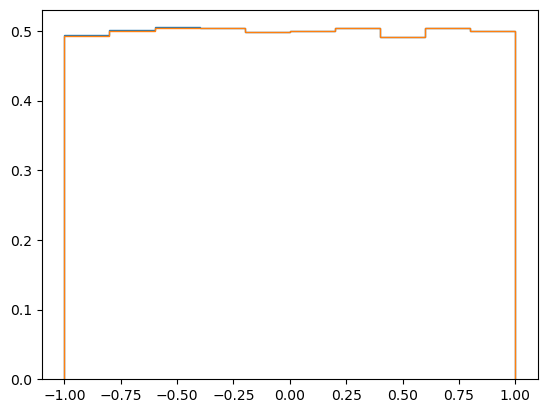

In [69]:
plt.hist(df_new["z"], density= True ,histtype='step' )
plt.hist(df_old["z"], density= True, histtype='step')

plt.show()

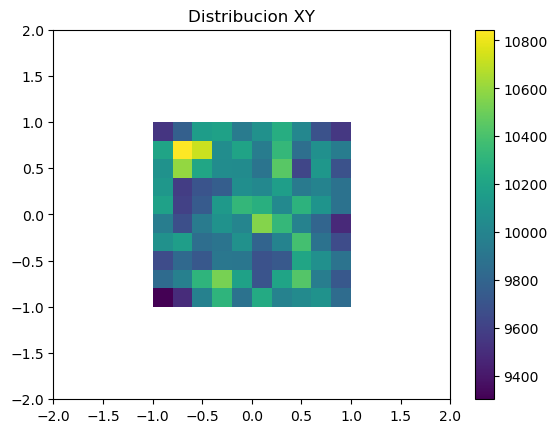

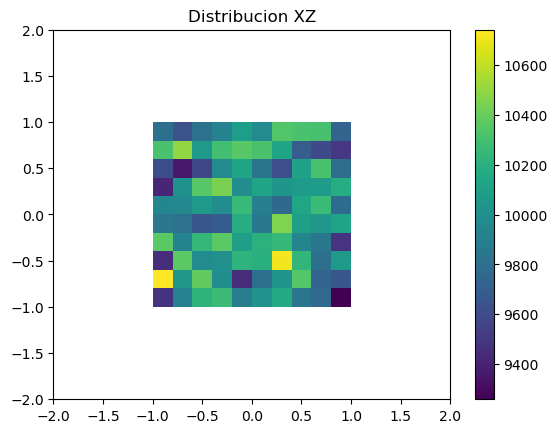

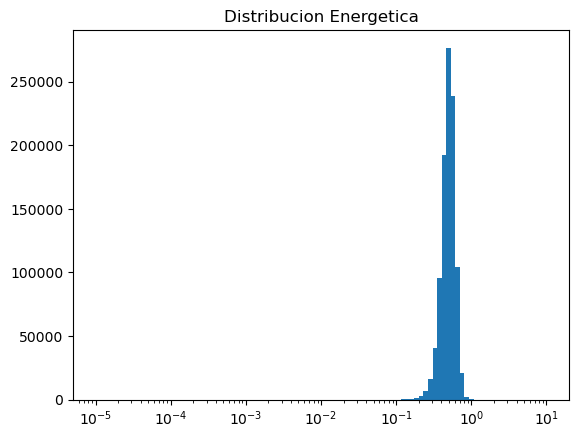

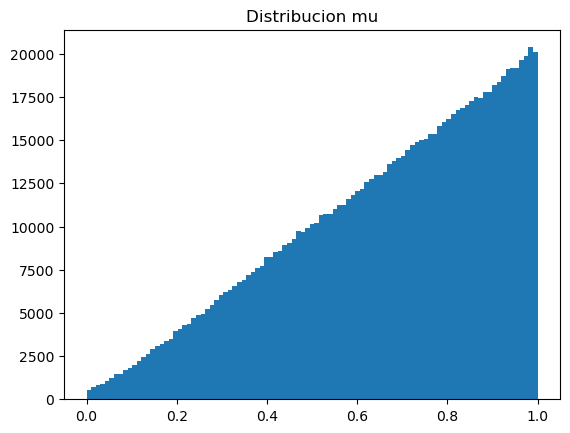

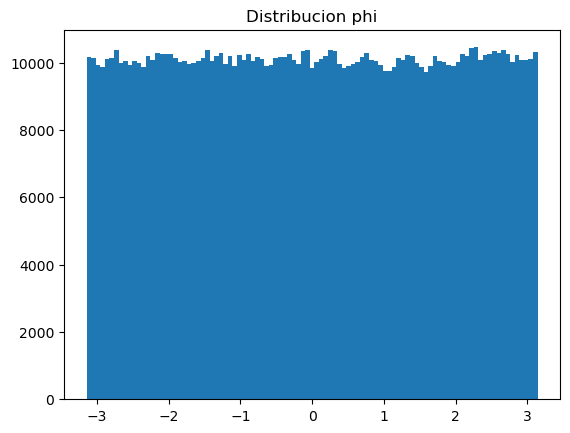

In [70]:
plt.hist2d(df_new["x"], df_new["y"])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title("Distribucion XY")
plt.colorbar()
plt.show()


plt.hist2d(df_new["x"], df_new["z"])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title("Distribucion XZ")
plt.colorbar()
plt.show()


bins = np.logspace(-5,1,100)
plt.hist(df_new["E"], bins=bins)
plt.title("Distribucion Energetica")
plt.xscale("log")
plt.show()

bins = np.linspace(0,1,100)
plt.hist(df_new["mu"], bins=bins)
plt.title("Distribucion mu")
plt.show()

bins = np.linspace(-np.pi,np.pi,100)
plt.hist(df_new["phi"], bins=bins)
plt.title("Distribucion phi")
plt.show()